In [ ]:
import numpy as np
from skimage import io
from pathlib import Path
import re
#import ants
from skimage.transform import resize
from tqdm import tqdm
from skimage.morphology import skeletonize_3d, binary_closing
from scipy.ndimage import distance_transform_edt, binary_dilation
import tifffile as tif
from scipy.ndimage import binary_fill_holes
import cc3d
from scipy.io import loadmat, savemat
import sknw
import networkx as nx
import pickle
import os
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy as sp
import vg
from pytransform3d.rotations import matrix_from_axis_angle
import multiprocessing
from scipy.ndimage import convolve as conv
from scipy.stats import multivariate_normal
from skimage import color, data, restoration
#from RedLionfishDeconv import doRLDeconvolutionFromNpArrays
from matplotlib.patches import Circle
from skimage.feature import peak_local_max
from statistics import mode
import imageio
from PIL import Image
from PIL.TiffTags import TAGS
from tifffile import TiffFile
from sklearn.metrics import normalized_mutual_info_score, adjusted_mutual_info_score
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
def remove_small_comps_3d(image, thresh = 100):
    """

    Parameters
    ----------
    image : binary np array with uint8 elements
        3d numpy matrix, connected components will be removed form this image
    thresh : int64
        smallest connected components to keep

    Returns
    -------
    np.array with uint8 elements, binary
        binary image with connected components below the threshold removed.

    """
    img_lab, N = cc3d.connected_components(image,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    unique_keep = unique[counts>thresh]
    unique_keep = np.delete(unique_keep,[0])
    img_filt = np.zeros(img_lab.shape).astype('int8')
    img_filt[np.isin(img_lab,unique_keep)] = 1
    return img_filt.astype('uint8')

def _rotmat(vector, points):
    """
    Rotates a 3xn array of 3D coordinates from the +z normal to an
    arbitrary new normal vector.
    """
    
    vector = vg.normalize(vector)
    axis = vg.perpendicular(vg.basis.z, vector)
    angle = vg.angle(vg.basis.z, vector, units='rad')
    
    a = np.hstack((axis, (angle,)))
    R = matrix_from_axis_angle(a)
    
    r = sp.spatial.transform.Rotation.from_matrix(R)
    rotmat = r.apply(points)
    
    return rotmat

def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    if np.min(dist_2)>10:
        return node
    else:
        return nodes[np.argmin(dist_2)]

In [3]:
folder = Path('beads')
files = folder.glob('*/*.tif')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if 'more_diluted' in x]
files = [x for x in files if '_seg' not in x]
files = [x for x in files if '_up' not in x]
files[0:5]
print(len(files))

20


In [ ]:
img = np.max(io.imread(files[0])[:,0],axis=0).flatten()
for file in tqdm(files[1:]):
    img = np.concatenate((img,np.max(io.imread(file)[:,0],axis=0).flatten()))

In [ ]:
plt.hist(img,bins=1000)
plt.ylim(0,2000)
plt.show()

In [ ]:
res = []
thresh=350
for file in tqdm(files):
    img = io.imread(file)[:,0]
    img = img + np.random.normal(scale=85,size=img.shape).astype('int16')
    seg = np.zeros(img.shape)
    seg[img>thresh] = 1
    sig = np.mean(img[seg==1])
    noise = np.mean(img[seg!=1])
    res.append(sig/noise)
print(res)

In [ ]:
#np.random.normal(scale=100,size=img.shape).astype('int16')

In [ ]:
print(np.mean(res))
print(np.std(res))

In [ ]:
thresh=350
for file in tqdm(files):
    img = io.imread(file)[:,0]
    img = sp.ndimage.zoom(img,(2.645833333,1,1))
    a, b, c = np.mgrid[-15:16:1, -15:16:1, -15:16:1]
    abc = np.dstack([a.flat,b.flat, c.flat])
    mu = np.array([0,0,0])
    sigma = np.array([0.636,0.127,0.127])
    covariance = np.diag(sigma**2)
    d = multivariate_normal.pdf(abc, mean=mu, cov=covariance)
    d = d.reshape((len(a),len(b),len(c)))
    deconv_img = np.copy(img)
    deconv_img =  1023 * restoration.richardson_lucy(img/1023.0, d, iterations=10)
    deconv_img = np.int16(deconv_img)
    seg = np.zeros(img.shape)
    seg[img>thresh] = 1
    io.imsave(re.sub('.tif','_seg.tif',file),seg.astype('int8'))
    io.imsave(re.sub('.tif','_up_deconv.tif',file),img)
    plt.imshow(np.max(img,axis=0))
    plt.show()

In [4]:
folder = Path('beads')
files = folder.glob('*/*_seg.tif')
files = sorted([x.as_posix() for x in files])

In [5]:
folder = Path('beads')
files = folder.glob('*/*_seg.tif')
files = sorted([x.as_posix() for x in files])
files = [x for x in files if 'more_diluted' in x]
#files = [x for x in files if '_seg' not in x]
len(files)

20

In [23]:
nreps = 1
RES = []
sampling = 1/5
res = []
for file in tqdm(files):
    seg = io.imread(file)
    seg = remove_small_comps_3d(seg)
    img = io.imread(re.sub('_seg','_up_deconv',file))
    img = img + np.random.normal(scale=85,size=img.shape).astype('int16')
    img_lab, N = cc3d.connected_components(seg,return_N=True)
    unique, counts = np.unique(img_lab, return_counts=True)
    res.append(counts[1:])
    #img_lab = np.max(img_lab,axis=0)
    #seg = np.max(seg,axis=0)
    #img = np.max(img,axis=0)
    for i in unique[1:]:
        centroid = np.mean(np.argwhere(img_lab==i),axis=0)
        centroid_x, centroid_y, centroid_z = int(centroid[0]), int(centroid[1]), int(centroid[2])
        #print(centroid_x,centroid_y,centroid_z)
        centroid = np.array([centroid_x,centroid_y,centroid_z])
        
        _pred_radii = (3*np.sum(img_lab==i)/(np.pi*4))**(1/3)
        #if _pred_radii == 0:
        #    _pred_radii =1
        
        _box_fit = max([np.int16(_pred_radii)+10, 15])

        path_grad = np.random.uniform(low=-1, high=1.0, size=(nreps,3))
        res_fwhm = []
        X = np.arange(-1*_box_fit,_box_fit+1,1)
        Y = np.arange(-1*_box_fit,_box_fit+1,1)
        x,y = np.meshgrid(X,Y)
        x = x.flatten()
        y = y.flatten()
        z = np.zeros(len(x))
        xy = np.vstack([x,y,z])
        
        
        res_fwhm = []
        
        res_fwhm_sigma = []
        
        #for I in range(nreps):
        def calc_fwhm_path(I):
            point_grad = path_grad[I]
            point = centroid
            if all(point_grad[0:2] == [0,0]) and abs(point_grad[2]/point_grad[2]) == 1:
                rotated = xy.T + point
            else:
                rotated = _rotmat(point_grad,xy.T) + point
            points_img = sp.ndimage.map_coordinates(#np.int16(mean[1]*1024),
                                                img,
                                                rotated.T, 
                                                order=3,
                                                mode='constant')
            
                    
            points_img = np.reshape(points_img,(len(X),len(Y)))
            points_img_no_smooth = np.copy(points_img)
            points_img = sp.ndimage.gaussian_filter(points_img, sigma = _pred_radii*.4)
            #plt.imshow(points_img)
            #plt.show()
            
            _point = np.array(np.arange(0,_pred_radii+20,sampling))
            _zeros = np.zeros(len(_point))
            _point = np.array([_point,_zeros])
            _centre = closest_node([len(X)//2+1,len(Y)//2+1],peak_local_max(points_img.T))
            
            _res = []
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
            for deg in np.arange(0,360,120):
                rot_point = np.dot(np.array([[np.cos(np.deg2rad(deg)),-1*np.sin(np.deg2rad(deg))],[np.sin(np.deg2rad(deg)),np.cos(np.deg2rad(deg))]]),_point)
                rot_point[0] = rot_point[0] + _centre[0]
                rot_point[1] = rot_point[1] + _centre[1]
                points_vals = sp.ndimage.map_coordinates(points_img.T,
                                                         rot_point, 
                                                         order=3,
                                                         cval=0)
                points_vals = sp.ndimage.gaussian_filter1d(points_vals,sigma=_pred_radii*.4/sampling)
                points_vals_grad = np.gradient(points_vals)
                _ = np.array(sp.signal.argrelextrema(points_vals + np.random.uniform(-1e-5,1e-5,len(points_vals)),np.less,order=3))
                if _.shape[1] != 0:
                    points_vals_grad = np.gradient(points_vals[:_[0,0]+3])
                    _ = np.argmin(points_vals_grad)
                    _res.append(_*sampling)
                    #ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
                else:
                    points_vals_grad = np.gradient(points_vals)
                    _ = np.argmin(points_vals_grad)
                    _res.append(_*sampling)
                    #ax.scatter(_*sampling*np.cos(np.deg2rad(deg))+_centre[0],_*sampling*np.sin(np.deg2rad(deg))+_centre[1],color='r')
            _res = np.array(_res)
            _res = _res[~np.isnan(_res)]
            _res = _res[np.where(_res!=0)]
            _mean = np.mean(_res)
            _std = np.std(_res)
            _mask = np.where(np.logical_and(_res>_mean-2*_std, _res<_mean+2*_std))
            _res = _res[_mask]
            radii = np.mean(_res)
            radii_std = np.std(_res)
            circ = Circle(_centre,radii,fill=False)
            #print(radii)
            #print(radii_std)
            #ax.add_patch(circ)
            #ax.set_title(radii)
            #fig.savefig('/home/rozakmat/scratch/_tmp/'+re.sub('matt_raw_warped_upsampled_seg/','',re.sub('_warped.pickle','',file))+str(i)+'_'+str(I)+'.png')
            #fig.show()
            #plt.clf()
            
                
            return radii, radii_std
        pool = multiprocessing.Pool(nreps)
        _vals, _vals_sigma = zip(*pool.map(calc_fwhm_path, range(nreps)))
        RES.append(np.mean(_vals)*2)

100%|██████████| 20/20 [29:01<00:00, 87.06s/it] 


In [24]:
RES = [x for x in RES if x == x]
print(len(RES))
print(np.mean(RES))
print(np.std(RES))
#RES

289
7.536793540945792
0.6834813911482442


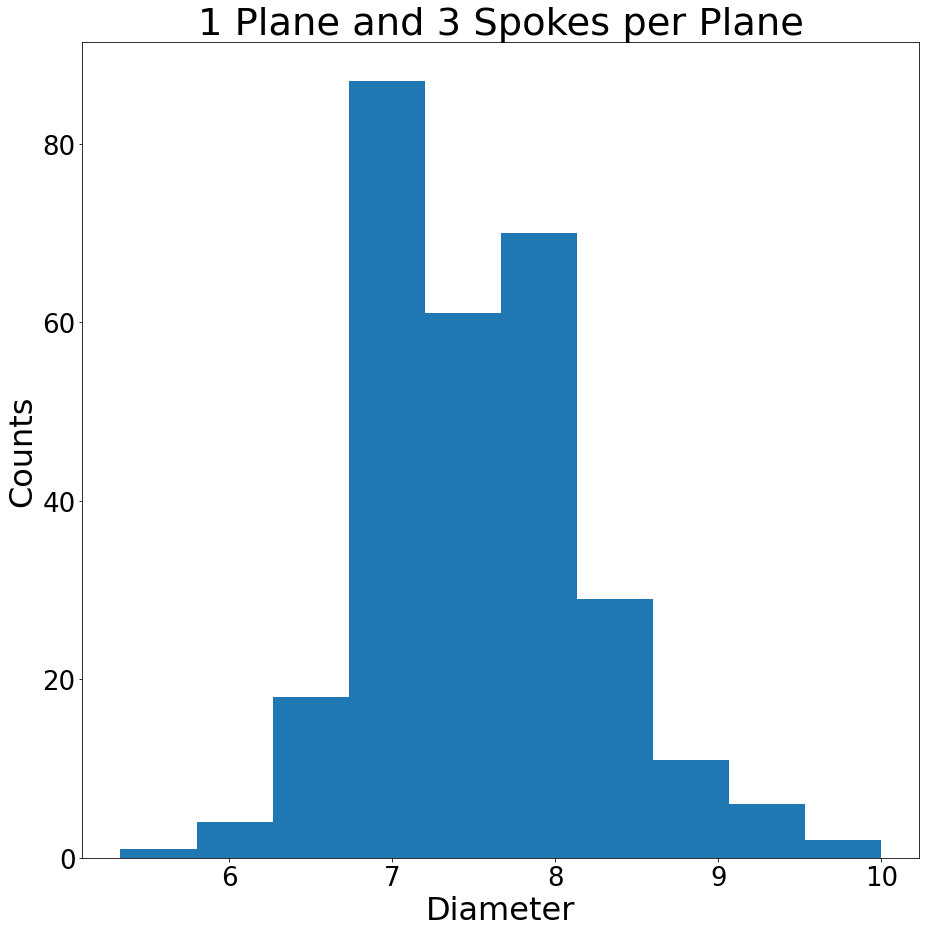

In [25]:
import matplotlib 
matplotlib.rc('xtick', labelsize=26) 
matplotlib.rc('ytick', labelsize=26)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 32}

matplotlib.rc('font', **font)
plt.hist(RES)
plt.xlabel('Diameter')
plt.ylabel('Counts')
plt.title(str(nreps)+' Plane and 3 Spokes per Plane')
plt.savefig('1plane3spokes_wn.png')
plt.show()

In [ ]:
RES_4_4 = RES

In [ ]:
(3*np.sum(img_lab==i)/(np.pi*4))**(1/3)

In [ ]:
print(np.mean(RES_36_4))
print(np.std(RES_36_4))

In [ ]:
print(np.mean(RES_4_4))
print(np.std(RES_4_4))